In [1]:
import autograd 

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

import sys
sys.path.insert(0, '../')

import structure_model_lib
import data_utils
import paragami

import structure_optimization_lib as str_opt_lib

import LinearResponseVariationalBayes.ExponentialFamilies as ef

In [2]:
from BNP_modeling import cluster_quantities_lib, modeling_lib
import BNP_modeling.optimization_lib as opt_lib
import cavi_lib

from itertools import permutations

import matplotlib.pyplot as plt
%matplotlib inline  

import vittles

from copy import deepcopy

In [3]:
np.random.seed(53453)

In [4]:
# def check_hessian(vb_sens, vb_opt_free_params, prior_free_params, which_prior): 
    
#     # get hessian inverse 
#     hess_inverse = vb_sens.hess_solver.solve(np.eye(len(vb_opt_free_params)))
    
#     # gradient wrt to vb free parameters
#     vb_opt_grad = vb_sens._obj_fun_grad(vb_opt_free_params, prior_free_params)
    
#     # get the direction of the next Newton step
#     step = - vb_sens.hess_solver.solve(vb_opt_grad)
    
#     # This is the second term of the derivative
#     def get_term2_objective(vb_sens, vb_opt_free_params, prior_free_params, which_prior): 
#         cross_hess = vb_sens._hyper_obj_cross_hess(vb_opt_free_params, prior_free_params)

#         cross_hess_prior = np.einsum('nj, j -> n', cross_hess, which_prior)

#         return -np.einsum('nj, j -> n', hess_inverse, cross_hess_prior)
    
#     get_term2_derivative = vittles.sensitivity_lib._append_jvp(get_term2_objective, 
#                                                                num_base_args = 4, 
#                                                                argnum = 1)
    
#     term2_derivative = get_term2_derivative(vb_sens, vb_opt_free_params, prior_free_params, which_prior, step)
    
#     # this is the third term of the derivative 
#     def get_term3_objective(vb_sens, vb_opt_free_params, prior_free_params, which_prior): 
#         vb_grad = vb_sens._obj_fun_grad(vb_opt_free_params, prior_free_params)
#         return np.dot(hess_inverse, vb_grad)
    
#     _get_term3_derivataive = vittles.sensitivity_lib._append_jvp(get_term3_objective, 
#                                    num_base_args = 4, 
#                                    argnum = 1)
    
#     get_term3_derivative = vittles.sensitivity_lib._append_jvp(_get_term3_derivataive, 
#                                    num_base_args = 5, 
#                                    argnum = 1)
#     sens_mat = np.einsum('nj, j -> n', vb_sens._sens_mat, which_prior)
    
#     term3_derivative = get_term3_derivative(vb_sens, vb_opt_free_params, prior_free_params, 
#                                             which_prior, sens_mat, step)
    
#     return term2_derivative + term3_derivative

# Draw data

In [5]:
n_obs = 40
n_loci = 50
n_pop = 4

# population allele frequencies
true_pop_allele_freq = np.random.random((n_loci, n_pop))

# individual admixtures
true_ind_admix_propn = np.random.dirichlet(np.ones(n_pop) / n_pop, size = (n_obs))

In [6]:
clustering_indx = data_utils.cluster_admix_get_indx(true_ind_admix_propn)
true_ind_admix_propn = true_ind_admix_propn[clustering_indx, :]

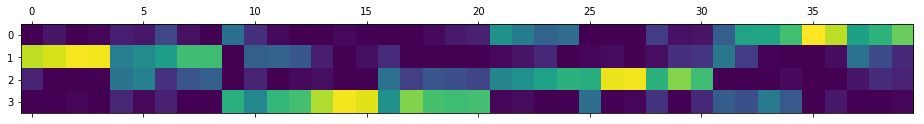

In [7]:
plt.matshow(true_ind_admix_propn.T)

In [8]:
g_obs = data_utils.draw_data(true_pop_allele_freq, true_ind_admix_propn)

In [9]:
g_obs.shape

(40, 50, 3)

# Get prior

In [10]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_free_params = prior_params_paragami.flatten(prior_params_dict, free=True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [11]:
use_logitnormal_sticks = False

In [12]:
k_approx = 6

In [13]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [14]:
vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx, use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (50, 6, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_beta_params] = NumericArrayPattern (40, 5, 2) (lb=0.0, ub=inf)


## Initialize 

In [15]:
vb_params_dict = structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict, 
                                                        use_logitnormal_sticks)

In [16]:
# take a look at init 
if use_logitnormal_sticks: 
    e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                        vb_params_dict['ind_mix_stick_propn_mean'], 
                        vb_params_dict['ind_mix_stick_propn_info'],
                        gh_loc, gh_weights)

else: 
    # take a look at init 
    ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
    e_stick_lengths = \
            modeling_lib.get_e_beta(ind_mix_stick_beta_params)
    e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])

In [17]:
if k_approx < 6: 
    # find minimizing permutation 
    # only feasible if k_approx is small, 
    # else my computer freezes
    perm = data_utils.find_min_perm(e_pop_freq, true_pop_allele_freq, axis = 1)
else: 
    perm = np.arange(k_approx)
    
e_pop_freq = e_pop_freq[:, perm]
e_ind_admix = e_ind_admix[:, perm]

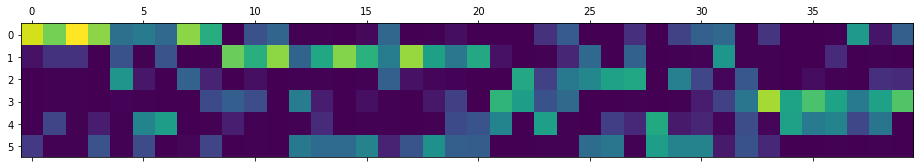

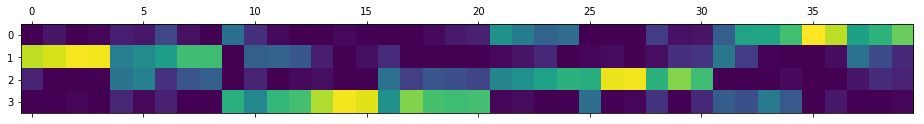

In [18]:
plt.matshow(e_ind_admix.T); 
plt.matshow(true_ind_admix_propn.T);

# Run CAVI

In [19]:
e_log_sticks, e_log_1m_sticks, \
    e_log_pop_freq, e_log_1m_pop_freq = \
        structure_model_lib.get_moments_from_vb_params_dict(g_obs, vb_params_dict, use_logitnormal_sticks)

In [20]:
e_z, stick_beta_params, pop_beta_params = \
    cavi_lib.run_cavi(g_obs, e_log_pop_freq, e_log_1m_pop_freq,
                e_log_sticks, e_log_1m_sticks,
                prior_params_dict, 
                max_iter = 2000, f_tol = 1e-2)

iteration [0]; kl:3952.608162
iteration [1]; kl:3392.455286
iteration [2]; kl:3303.661196
iteration [3]; kl:3277.030543
iteration [4]; kl:3264.05157
iteration [5]; kl:3255.748158
iteration [6]; kl:3249.762555
iteration [7]; kl:3245.140411
iteration [8]; kl:3241.393956
iteration [9]; kl:3238.246244
iteration [10]; kl:3235.529129
iteration [11]; kl:3233.134617
iteration [12]; kl:3230.989707
iteration [13]; kl:3229.04276
iteration [14]; kl:3227.255823
iteration [15]; kl:3225.600129
iteration [16]; kl:3224.053327
iteration [17]; kl:3222.597673
iteration [18]; kl:3221.218805
iteration [19]; kl:3219.90488
iteration [20]; kl:3218.645959
iteration [21]; kl:3217.433569
iteration [22]; kl:3216.260393
iteration [23]; kl:3215.120061
iteration [24]; kl:3214.007007
iteration [25]; kl:3212.916375
iteration [26]; kl:3211.843963
iteration [27]; kl:3210.786181
iteration [28]; kl:3209.740023
iteration [29]; kl:3208.703039
iteration [30]; kl:3207.673314
iteration [31]; kl:3206.649453
iteration [32]; kl:32

In [21]:
# check results after CAVI steps

In [22]:
# Set VB parameters
if use_logitnormal_sticks: 
    # convert beta params to logitnormal
    raise NotImplementedError()
else: 
    vb_params_dict['pop_freq_beta_params'] = pop_beta_params
    vb_params_dict['ind_mix_stick_beta_params'] = stick_beta_params

In [23]:
e_pop_allele_freq = modeling_lib.get_e_beta(pop_beta_params)

In [24]:
if k_approx < 6: 
    perm_best = data_utils.find_min_perm(e_pop_allele_freq, true_pop_allele_freq, axis = 1)
else: 
    perm_best = perm

In [25]:
ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
e_stick_lengths = \
        modeling_lib.get_e_beta(ind_mix_stick_beta_params)
e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)[:, perm_best]

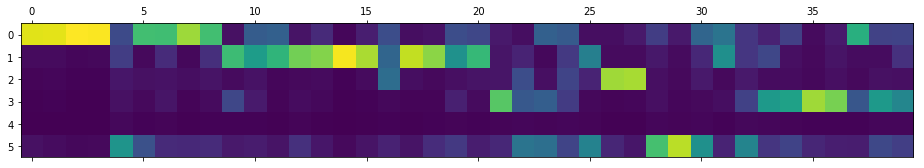

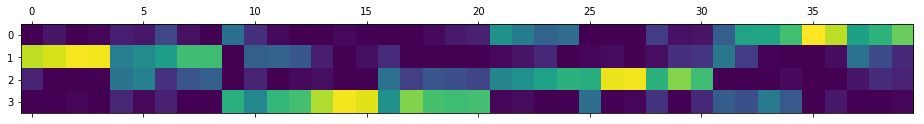

In [26]:
plt.matshow(e_ind_admix.T); 
plt.matshow(true_ind_admix_propn.T);

In [27]:
vb_params_dict_cavi = deepcopy(vb_params_dict)

# Check Hessian here?

Would have checked at the init, but its not even PSD

In [28]:
get_kl_from_vb_free_prior_free = paragami.FlattenFunctionInput(original_fun=structure_model_lib.get_kl, 
                                    patterns = [vb_params_paragami, prior_params_paragami],
                                    free = True,
                                    argnums = [1, 2])

In [29]:
vb_sens_cavi = \
        vittles.HyperparameterSensitivityLinearApproximation(
            objective_fun = lambda x, y: get_kl_from_vb_free_prior_free(g_obs, x, y, gh_loc, gh_weights, 
                                                                        use_logitnormal_sticks),
            opt_par_value = vb_params_paragami.flatten(vb_params_dict_cavi, free = True), 
            hyper_par_value = prior_free_params,
            validate_optimum=False,
            hessian_at_opt=None,
            cross_hess_at_opt=None,
            factorize_hessian=True,
            hyper_par_objective_fun=None,
            grad_tol=1e-8)

In [30]:
vb_cavi_free_params = vb_params_paragami.flatten(vb_params_dict_cavi, free = True)
which_prior = np.array([1., 0., 0.])

hessian_dir = str_opt_lib.check_hessian(vb_sens_cavi, which_prior)

In [31]:
np.max(np.abs(hessian_dir))

5.776002515704467

# run a few Netwon steps

In [32]:
# get loss as a function of vb parameters
get_free_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=structure_model_lib.get_kl, 
                                patterns = vb_params_paragami,
                                free = True,
                                argnums = 1)

get_free_vb_params_loss_cached = \
    lambda x : get_free_vb_params_loss(g_obs, x, prior_params_dict, gh_loc, gh_weights, 
                                       use_logitnormal_sticks)

In [33]:
init_vb_free_params = vb_params_paragami.flatten(vb_params_dict_cavi, free = True)

In [34]:
get_free_vb_params_loss_cached(init_vb_free_params)

3175.442776694376

In [35]:
vb_opt_free_params = opt_lib.optimize_full(get_free_vb_params_loss_cached, init_vb_free_params,
                    bfgs_max_iter = 0, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8,
                    init_hessian = None)


 running preconditioned newton; iter =  0
computing preconditioner 
preconditioning time: 22.22
running newton steps
Iter 0: f = 3175.44277669
Iter 1: f = 3176.09690538
Iter 2: f = 3175.15671510
Iter 3: f = 3175.09140021
Iter 4: f = 3174.92370740
Iter 5: f = 3174.78977002
Iter 6: f = 3174.63394759
Iter 7: f = 3174.57265775
Iter 8: f = 3174.49406867
Iter 9: f = 3174.32066220
Iter 10: f = 3174.22238494
Iter 11: f = 3174.01849622
Iter 12: f = 3173.91218231
Iter 13: f = 3173.82322502
Iter 14: f = 3173.74960479
Iter 15: f = 3173.71617281
Iter 16: f = 3173.50816843
Iter 17: f = 3172.27705463
Iter 18: f = 3173.15051989
Iter 19: f = 3169.85879678
Iter 20: f = 3167.17131387
Iter 21: f = 3164.87592738
Iter 22: f = 3162.54504864
Iter 23: f = 3161.38777180
Iter 24: f = 3160.27034276
Iter 25: f = 3160.16482672
Iter 26: f = 3160.06079157
Iter 27: f = 3160.00788837
Iter 28: f = 3158.67862204
Iter 29: f = 3157.71418712
Iter 30: f = 3158.32908807
Iter 31: f = 3157.32955017
Iter 32: f = 3157.06114908
I

In [36]:
vb_params_dict_newton = vb_params_paragami.fold(vb_opt_free_params, free = True)

In [37]:
e_pop_allele_freq = modeling_lib.get_e_beta(vb_params_dict_newton['pop_freq_beta_params'])

In [38]:
if k_approx < 6: 
    perm_best = data_utils.find_min_perm(e_pop_allele_freq, true_pop_allele_freq, axis = 1)
else: 
    perm_best = perm

In [39]:
ind_mix_stick_beta_params = vb_params_dict_newton['ind_mix_stick_beta_params']
e_stick_lengths = \
        modeling_lib.get_e_beta(ind_mix_stick_beta_params)
e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)[:, perm_best]

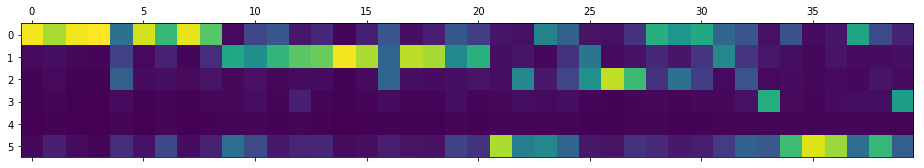

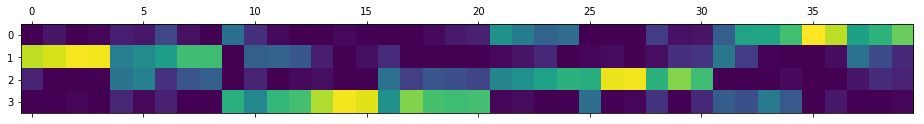

In [40]:
plt.matshow(e_ind_admix.T); 
plt.matshow(true_ind_admix_propn.T);

# Lets take a look at the hessian

In [41]:
vb_sens = \
        vittles.HyperparameterSensitivityLinearApproximation(
            objective_fun = lambda x, y: get_kl_from_vb_free_prior_free(g_obs, x, y, gh_loc, gh_weights, 
                                                                        use_logitnormal_sticks),
            opt_par_value = vb_opt_free_params,
            hyper_par_value = prior_free_params,
            validate_optimum=False,
            hessian_at_opt=None,
            cross_hess_at_opt=None,
            factorize_hessian=True,
            hyper_par_objective_fun=None,
            grad_tol=1e-8)

In [42]:
hessian_dir = str_opt_lib.check_hessian(vb_sens, which_prior)

In [43]:
np.max(np.abs(hessian_dir))

4.48278065356914e-09